# Comparison to GSTools

 Cover 4 cases: 
 1) No nugget effect, data points off grid
 2) No nugget effect, data points on grid
 3) Nugget effect, data points off grid
 4) Nugget effect, data points on grid


GStools offers an easy way to create stationary Gaussian fields.

Sebastian Müller, & Lennart Schüler. (2019, January 18). *GeoStat-Framework/GSTools: Bouncy Blue (Version v1.0.1).* Zenodo. http://doi.org/10.5281/zenodo.2543658

While this module uses a Seuquential Gaussian Simulation approach to create Gaussian fields, GStools utilises a spectral method described in:

Heße, F., Prykhodko, V., Schlüter, S., & Attinger, S. (2014). *Generating random fields with a truncated power-law variogram: A comparison of several numerical methods.* Environmental Modelling and Software, 55, 32-48.

In the following notebook both methods will be compared to show the basic similarities (and differences). 

##  Creating a simple GemPy model

In a first step we create a simple GemPy model consisting of a basement and two units named "rock1" and "rock2". The layering is completetely horizontal and while model is theoretically 3D, we only have a single point depth in y driection, basically creating a single 2D cross-section. For a more detailed description take a look at the gempy
tutorials.

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.pardir= '../..'
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
# import the kriging module
import importlib
from gempy.assets import kriging
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [5]:
#calcualte the solution
sol = gp.compute_model(geo_data, compute_mesh=False)

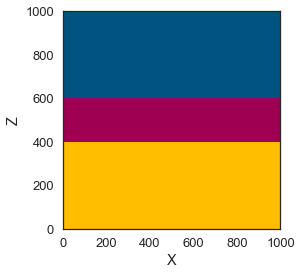

In [6]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

## The basic setup

In order to create both approaches used variograms have to be identical. Additionally the locations passed to GStools (grid) need to be the same as created by gempy.

In [7]:
# import the stuff from GStools
from gstools import krige
from gstools import SRF, Exponential
import gstools as gs

In [12]:
#test_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])
cond_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

# convert to GStools format
x_cond = test_data[:,0]
y_cond = test_data[:,2]
cond_val = test_data[:,3]
x = range(0,1000,20)
y = range(400,600,20)

In [18]:
range_ = 200
sill = np.var(cond_val)
nugget = 2

In [25]:
# create preliminary gempy kriging objects
domain = kriging.domain(sol, domain=[2], data=cond_data)
variogram_model = kriging.variogram_model('exponential', range_, sill, nugget)

In [29]:
# create preliminiary GStools stuff
model = Exponential(dim=2, var=sill-nugget , len_scale=range_, nugget=nugget)

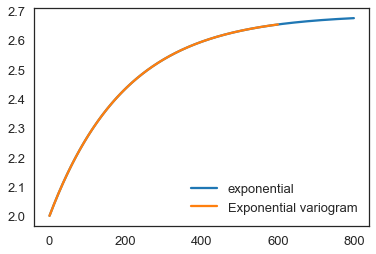

In [37]:
# Compare used variograms (exponential)
fig, ax = plt.subplots()

# GStools plotting option
variogram_model.plot()
gs.covmodel.plot.plot_variogram(model, ax=ax)


In [39]:
# Gempy module calculation
kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

kriging_model.range_ = 200
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 2
kriging_model.sill = np.var(cond_val)

kriging_model.create_kriged_field()
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values

In [15]:
print(np.max(prop))
print(np.min(prop))
print(np.mean(prop))

2.7982913552430766
1.8821964293170272
2.19922672679857


In [16]:
# Example with GSTools

C:\Users\Jan\Anaconda3\envs\gempy_env\lib\site-packages\gstools\field\plot.py:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


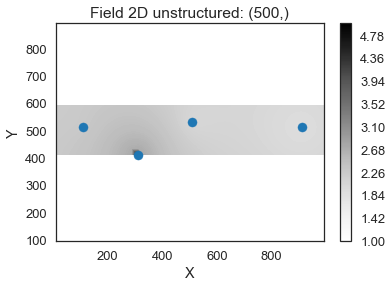

In [17]:
# Kriged field

# they use other sill - increase with nugget effect

model = Exponential(dim=2, var=np.var(cond_val)-2 , len_scale=200, nugget=2)

srf = krige.Ordinary(model, cond_pos=(x_cond, y_cond), cond_val=cond_val)
field = srf((x, y), mesh_type='unstructured')

fig, ax = plt.subplots()
ax.axis('equal')
srf.plot(fig=fig, ax=ax)
ax.scatter(x_cond, y_cond)

In [18]:
print(np.max(field[0]))
print(np.min(field[0]))
print(np.mean(field[0]))

5.000000000000001
0.9999999999999998
2.1992267267985697


In [19]:
print(field[0].shape)

(500,)


In [20]:
#kriging_model.krig_grid.shape

In [21]:
#srf.pos[0]

In [23]:
from mpl_toolkits.mplot3d import Axes3D

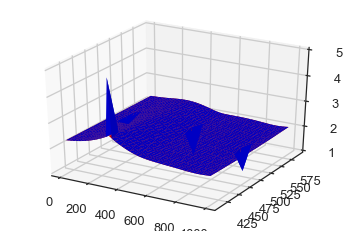

In [24]:
# Comparison as 3D surface plot:
Xs1 = kriging_model.results_df['X'].values
Ys1 = kriging_model.results_df['Z'].values
Zs1 = kriging_model.results_df['est_value'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[0]

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)

#fig.colorbar(surf1)

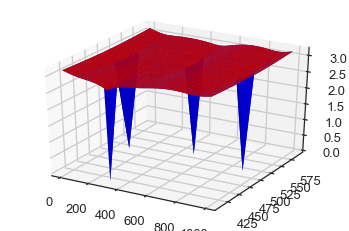

In [25]:
# Comparison as 3D surface plot:
Xs1 = kriging_model.results_df['X'].values
Ys1 = kriging_model.results_df['Z'].values
Zs1 = kriging_model.results_df['est_variance'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[1]

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)